In [1]:
# Import all necessity functions for Machine Learning
import sys
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import zipfile
import cv2
import os
import random
from collections import Counter
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, silhouette_score

In [2]:
# Remove all warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# To Access the Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
# To Unzip the folder
link_folder = '/content/drive/MyDrive/CNN Dataset/malaria-disease-classification.zip'
zip_ref = zipfile.ZipFile(link_folder, 'r')
zip_ref.extractall()
zip_ref.close()

In [5]:
# Extract the data
DIRECTORY   = '/content/Monkeypox'
CATEGORIES  = ['Monkeypox', 'Normal']
IMAGE_DATA  = []
IMAGE_LABEL = []
STORE_DATA  = []

for folder_name in CATEGORIES:
    FULL_PATH = os.path.join(DIRECTORY, folder_name)

    for image_file in os.listdir(FULL_PATH):
        FULL_IMAGE_PATH = os.path.join(FULL_PATH, image_file)

        try:
            # Read the image
            image = cv2.imread(FULL_IMAGE_PATH)
            if image is not None:
                # Make sure that all images would be in the same shape
                resized_image = cv2.resize(image, (120, 120))

                # Store the data and image label for future work
                IMAGE_DATA.append(resized_image)
                IMAGE_LABEL.append(CATEGORIES.index(folder_name))

                # Store the extracted data and label into STORE_DATA
                STORE_DATA.append([resized_image, CATEGORIES.index(folder_name)])

            else:
                print("Error reading image: {}".format(FULL_IMAGE_PATH))

        except Exception as e:
            print("Error processing image {}: {}".format(FULL_IMAGE_PATH, str(e)))

    print("{} is completed.".format(folder_name))

Monkeypox is completed.
Normal is completed.


In [6]:
random.shuffle(STORE_DATA)
print("Shuffle is completed.")

Shuffle is completed.


#####Separate the data into independent & dependent

In [7]:
X = []
y = []

for (independent, dependent) in STORE_DATA:
  X.append(independent)
  y.append(dependent)

#####Convert this data into NumPy

In [8]:
X = np.array(X)
y = np.array(y)

#####Do the normalization

In [9]:
X = X/255
print("Normalization is completed.")

Normalization is completed.


#####Shuffle the dataset

In [10]:
random.shuffle(STORE_DATA)
print("Shuffle is completed.")

Shuffle is completed.


#####Display some of the images

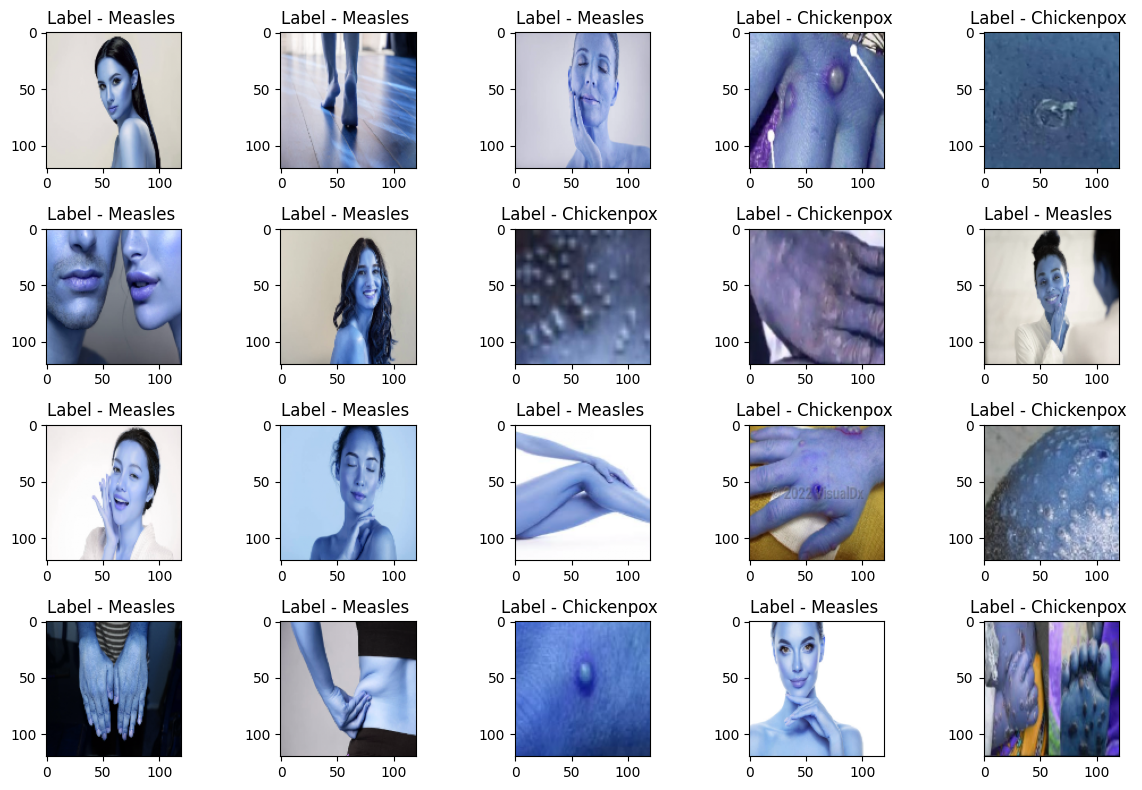

In [11]:
IMAGE = X[0:20]
LABEL = y[0:20]
plt.figure(figsize = (12, 8))
for index, image in enumerate(IMAGE):
  plt.subplot(4, 5, index + 1)
  plt.imshow(image)

  label = ""
  if LABEL[index] == 0:
    label = "Chickenpox"
  elif LABEL[index] == 1:
    label = "Measles"
  elif LABEL[index] == 2:
    label = "Monkeypox"
  else:
    label = "Normal"

  plt.title("Label - {} ".format(label))

plt.tight_layout()
plt.show()

#####Check the distribution of target class

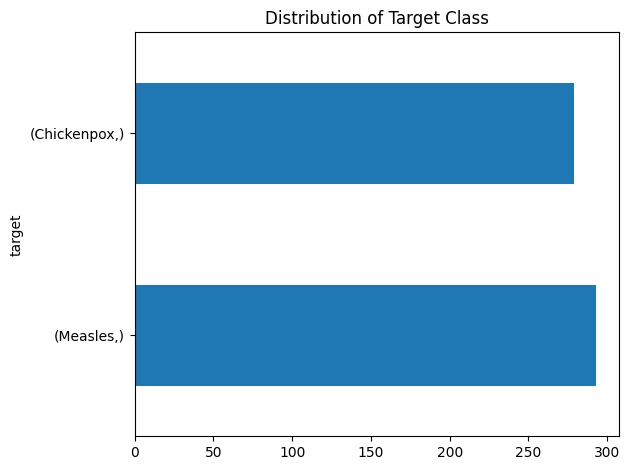

In [12]:
def changed_name(label = None):
  if label == 0:
    return "Chickenpox"
  elif label == 1:
    return "Measles"
  elif label == 2:
    return "Monkeypox"
  else:
    return "Normal"

pd.DataFrame(y, columns = ['target']).applymap(changed_name).value_counts().plot(kind = 'barh')
plt.title('Distribution of Target Class')
plt.tight_layout()
plt.show()

#####Import some libraries of PyTorch

In [13]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

#####Train and test split

In [14]:
"""
    1. Change the shape of Image that would acceptable for torch : (BATCH_SIZE, CHANNELS, HEIGHT, WIDTH)
    2. Split the dataset into Train and Test
    3. Convert the train and test data-type into Float with respect to torch
    4. Create TRAIN_LOADER & TEST_LOADER with batch_size 32
    5. Display the data and label with respect to loader
"""
X = X.reshape(X.shape[0], 3, 120, 120)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Convert this train and test into Float with respect to torch

X_train = torch.tensor(data = X_train, dtype = torch.float32)
y_train = torch.tensor(data = y_train, dtype = torch.float32)

X_test  = torch.tensor(data = X_test, dtype = torch.float32)
y_test  = torch.tensor(data = y_test, dtype = torch.float32)

# Call the DataLoader with batch_size: 32
BATCH_SIZE = 32

TRAIN_LOADER = DataLoader(dataset = list(zip(X_train, y_train)), batch_size = BATCH_SIZE, shuffle = True)
TEST_LOADER  = DataLoader(dataset = list(zip(X_test, y_test)), batch_size = BATCH_SIZE, shuffle = True)

train_data, train_label = next(iter(TRAIN_LOADER))
test_data , test_label  = next(iter(TEST_LOADER))

# Display the shape
print("Train batch_size # {} ".format(TRAIN_LOADER.batch_size),'\n')
print("Test batch_size  # {} ".format(TEST_LOADER.batch_size),'\n'*2)

print("Train data with batch_size shape  # {} ".format(train_data.shape),'\n')
print("Train label with batch_size shape # {} ".format(train_label.shape),'\n'*2)

print("Test data with batch_size shape   # {} ".format(test_data.shape),'\n')
print("Test label with batch_size shape  # {} ".format(test_label.shape))

Train batch_size # 32  

Test batch_size  # 32  


Train data with batch_size shape  # torch.Size([32, 3, 120, 120])  

Train label with batch_size shape # torch.Size([32])  


Test data with batch_size shape   # torch.Size([32, 3, 120, 120])  

Test label with batch_size shape  # torch.Size([32]) 


#####Call the GPU

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#####Model building

In [16]:
"""
    1. Create a class named PoxClassification with TWO parameters
      1.1 input_channel: Define whether the image is RGB or GRAY
      1.2 output_dimension: Define the target class. == 1 menas binary class and > 1 means multi-class classification
    2. Call the super function that will inherit the parent class of torch
"""
DROPOUT_RATE = 0.3
class PoxClassification(nn.Module):
  def __init__(self, input_channel = None, output_dimension = None):
    super().__init__()

    """
        Create the Left most, Middle most, Right most, Convolutional Layer that will take
          1. in_channels : Define the input_channels - in this case, 3(means RGB Image)
          2. out_channels : Define the output channels after being done the convolution operation
          3. kernel_size : Define the kernel/filter that will be placed on top of images so that we can extract the Feature Map
          4. stride : Define how much this kernel would be moved (TOP->BOTTOM->LEFT->RIGHT)
          5. padding : Define whether the Feature Map would be equivalent to orginal Image shape or not. == 1 means orginal & 0 == means might be changed.

        Define the Activation Layer so that we can pass the information to the subsequent layers/neurons. In this case, ReLU activation - prevent the vanishing gradient

        MaxPooling : Do the down-sampling on top of Feature Map so that we can prevent Translation invariance and overfitting problem
          1. kernel_size: In this case, (2, 2) - initially it would be filled with random numbers but it is trainable parameters
          2. stride : In this case, (2, 2) - The Feature map that we would be obtained would be half of the orginal Image

        Dropout : Dropout Layer is generally used to prevent the overfitting problem. In this case, 0.4 for all Convolutional Layer

        # Left Most Convolutional Layer
            Image Shape : 120 * 120 * 3 -> 60 * 60 * 16
        # Middle Most Convolutional Layer
            Image Shape : 120 * 120 * 3 -> 60 * 60 * 32
        # Right Most Convolutional Layer
            Image Shape : 120 * 120 * 3 -> 60 * 60 * 64 -> 30 * 30 * 32
    """
    # LEFT MOST CONVOLUTIONAL LAYER
    self.leftConv1 = nn.Sequential(
        nn.Conv2d(in_channels = input_channel, out_channels = 16, kernel_size = (3, 3), stride = (1, 1), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2)),
        nn.Dropout(p = DROPOUT_RATE)
    )
    # MIDDLE MOST CONVOLUTIONAL LAYER
    self.middleConv1 = nn.Sequential(
        nn.Conv2d(in_channels = input_channel, out_channels = 32, kernel_size = (3, 3), stride = (1, 1), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
        # nn.Dropout(p = DROPOUT_RATE)
    )

    # RIGHT MOST CONVOLUTIONAL LAYER 1
    self.rightConv1 = nn.Sequential(
        nn.Conv2d(in_channels = input_channel, out_channels = 64, kernel_size = (3, 3), stride = (1, 1), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2)),
        nn.Dropout(p = DROPOUT_RATE)
    )
    # RIGHT MOST CONVOLUTIONAL LAYER 2
    self.rightConv2 = nn.Sequential(
        nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = (3, 3), stride = (1, 1), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (2, 2), stride = (2, 2)),
        nn.Dropout(p = DROPOUT_RATE)
    )
    """
        Create the Sequentila Fully Connected Layer for LEFT, MIDDLE, RIGHT
          1. in_features : There, we will fill the Feature Map shape after being completed each Convolutional Operation
          2. out_features : There, Define how many neurons that we want
            2.1 Left : 32 -> 10
            2.2 Middle: 32 -> 10
            2.3 Right : 64 -> 32 ->10
    """
    # LEFT MOST
    self.leftFc1 = nn.Sequential(
        nn.Linear(in_features = 60 * 60 * 16, out_features = 128),
        nn.ReLU(),
        nn.Dropout(p = 0.1)
    )
    self.leftFc2 = nn.Sequential(
        nn.Linear(in_features = 128, out_features = 32),
        nn.ReLU(),
        nn.Dropout(p = 0.1)
    )
    self.leftOutput = nn.Sequential(
        nn.Linear(in_features = 32, out_features = output_dimension),
        nn.Softmax()
    )
    # MIDDLE Most
    self.middleFc1 = nn.Sequential(
        nn.Linear(in_features = 60 * 60 * 32, out_features = 32),
        nn.ReLU(),
        nn.Dropout(p = 0.1)
    )
    self.middleOutput = nn.Sequential(
        nn.Linear(in_features = 32, out_features = output_dimension),
        nn.Softmax()
    )
    # RIGHT MODT
    self.rightFc1 = nn.Sequential(
        nn.Linear(in_features = 30 * 30 * 32, out_features = 64),
        nn.ReLU(),
        nn.Dropout(p = 0.3)
    )
    self.rightFc2 = nn.Sequential(
        nn.Linear(in_features = 64, out_features = 32),
        nn.ReLU(),
        nn.Dropout(p = 0.1)
    )
    self.rightOutput = nn.Sequential(
        nn.Linear(in_features = 32, out_features = output_dimension),
        nn.Softmax()
    )
  def forward(self, x):
    """
        1. Pass the Independent Features to all LEFT, MIDDLE, RIGHT
        2. Definately, change their shape so that we can pass the result to the Fully Connected layer
        3. Return the three models like x1, x2, and x3
    """
    # LEFT MOST
    x1 = self.leftConv1(x)
    x1 = x1.reshape(x1.shape[0], -1)

    # MIDDLE MOST
    x2 = self.middleConv1(x)
    x2 = x2.reshape(x2.shape[0], -1)

    # RIGHT MOST
    x3 = self.rightConv1(x)
    x3 = self.rightConv2(x3)
    x3 = x3.reshape(x3.shape[0], -1)

    # LEFT OUT
    x1 = self.leftFc1(x1)
    x1 = self.leftFc2(x1)
    x1 = self.leftOutput(x1)

    # MIDDLE OUT
    x2 = self.middleFc1(x2)
    x2 = self.middleOutput(x2)

    # RIGHT OUT
    x3 = self.rightFc1(x3)
    x3 = self.rightFc2(x3)
    x3 = self.rightOutput(x3)

    return x1, x2, x3

In [17]:
# Call the model
try:
  model = PoxClassification(input_channel = 3, output_dimension = 2)
except Exception as e:
  print(e.with_traceback())
else:
  print(model.parameters)

<bound method Module.parameters of PoxClassification(
  (leftConv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (middleConv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (rightConv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
  )
  (rightConv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3)

In [18]:
# Display the summary of the model
summary(model = model.to(device), input_size = X_train.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 120, 120]             448
              ReLU-2         [-1, 16, 120, 120]               0
         MaxPool2d-3           [-1, 16, 60, 60]               0
           Dropout-4           [-1, 16, 60, 60]               0
            Conv2d-5         [-1, 32, 120, 120]             896
              ReLU-6         [-1, 32, 120, 120]               0
         MaxPool2d-7           [-1, 32, 60, 60]               0
            Conv2d-8         [-1, 64, 120, 120]           1,792
              ReLU-9         [-1, 64, 120, 120]               0
        MaxPool2d-10           [-1, 64, 60, 60]               0
          Dropout-11           [-1, 64, 60, 60]               0
           Conv2d-12           [-1, 32, 60, 60]          18,464
             ReLU-13           [-1, 32, 60, 60]               0
        MaxPool2d-14           [-1, 32,

In [19]:
# Print the total trainable parameters
TRAINABLE_PARAMS = 0
for name, params in model.named_parameters():
  if params.requires_grad == True:
    TRAINABLE_PARAMS = TRAINABLE_PARAMS + params.numel()
    print("Layer - {} & Trainable parameters # {} ".format(name, TRAINABLE_PARAMS).capitalize())
    print("_"*60)

print("\nTotal Trainable Parameters # {} ".format(TRAINABLE_PARAMS).upper())

Layer - leftconv1.0.weight & trainable parameters # 432 
____________________________________________________________
Layer - leftconv1.0.bias & trainable parameters # 448 
____________________________________________________________
Layer - middleconv1.0.weight & trainable parameters # 1312 
____________________________________________________________
Layer - middleconv1.0.bias & trainable parameters # 1344 
____________________________________________________________
Layer - rightconv1.0.weight & trainable parameters # 3072 
____________________________________________________________
Layer - rightconv1.0.bias & trainable parameters # 3136 
____________________________________________________________
Layer - rightconv2.0.weight & trainable parameters # 21568 
____________________________________________________________
Layer - rightconv2.0.bias & trainable parameters # 21600 
____________________________________________________________
Layer - leftfc1.0.weight & trainable parameters 

#####Connect GPU to model

In [20]:
model = model.to(device)

#####Define the loss & optimizer

In [21]:
LEARNING_RATE = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

#####Check point Initialization

In [22]:
# Define a checkpoint
def checkpoint(model = None, filename = None):
  torch.save(model.state_dict(), filename)

# Define a resume function
def resume(model = None, filename = None):
  model.load_state_dict(torch.load(filename))

#####Training the model

In [23]:
"""
    Define some variables named
    1. EPOCHS : Define how many times the code would be exceuted
    2. MODEL_TL : Define the model train loss
    3. MODEL_VL : Define the Model validation loss
    4. MODEL_ACC: Define the Model accuracy
    5. MODEL_VAL_ACC : Define the Model validation accuracy
"""
EPOCHS = 1000
MODEL1_TL  = []
MODEL2_TL  = []
MODEL3_TL  = []
MODEL1_VL  = []
MODEL2_VL  = []
MODEL3_VL  = []
MODEL1_ACC = []
MODEL2_ACC = []
MODEL3_ACC = []
MODEL1_VAL_ACC = []
MODEL2_VAL_ACC = []
MODEL3_VAL_ACC = []

###############################
#          Training           #
###############################
model.train()
"""
1. Run a loop with respect to EPOCHS
2. Extract the data and label from TRAIN_LOADER
3. Pass the data into the model - that will return three different models (model1, model2, model3)
4. Compute the loss functions and do the predictions
5. Do the backward propagation to update the weights and bias
"""
for epoch in range(EPOCHS):
  model1_total_train_loss = []
  model2_total_train_loss = []
  model3_total_train_loss = []
  model1_total_val_loss   = []
  model2_total_val_loss   = []
  model3_total_val_loss   = []
  model1_total_prediction = []
  model2_total_prediction = []
  model3_total_prediction = []
  model1_total_labels     = []
  model2_total_labels     = []
  model3_total_labels     = []
  model1_val_labels       = []
  model2_val_labels       = []
  model3_val_labels       = []
  model1_val_prediction   = []
  model2_val_prediction   = []
  model3_val_prediction   = []

  for (X_batch, y_batch) in TRAIN_LOADER:
    # Convert y_batch into long
    y_batch = y_batch.long()
    # Connect GPU to the X_batch and y_batch
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Do the predictions
    model1, model2, model3 = model(X_batch)
    # Compute the loss function
    model1_train_loss = loss_function(model1, y_batch)
    model2_train_loss = loss_function(model2, y_batch)
    model3_train_loss = loss_function(model3, y_batch)

    # Do the backward propagation step to update weights and bias
    optimizer.zero_grad()
    model1_train_loss.backward()
    model2_train_loss.backward()
    model3_train_loss.backward()

    # Store the train loss
    model1_total_train_loss.append(model1_train_loss.item())
    model2_total_train_loss.append(model2_train_loss.item())
    model3_total_train_loss.append(model3_train_loss.item())

    # Store the orginal train labels
    model1_total_labels.extend(y_batch.cpu().flatten().detach().numpy())
    model2_total_labels.extend(y_batch.cpu().flatten().detach().numpy())
    model3_total_labels.extend(y_batch.cpu().flatten().detach().numpy())

    # Store the predicted train labels
    model1_total_prediction.extend(torch.argmax(model1, 1).cpu().flatten().detach().numpy())
    model2_total_prediction.extend(torch.argmax(model2, 1).cpu().flatten().detach().numpy())
    model3_total_prediction.extend(torch.argmax(model3, 1).cpu().flatten().detach().numpy())

  # Compute the accuracy of training dataset
  model1_train_accuracy = accuracy_score(model1_total_labels, model1_total_prediction)
  model2_train_accuracy = accuracy_score(model2_total_labels, model2_total_prediction)
  model3_train_accuracy = accuracy_score(model3_total_labels, model3_total_prediction)

  MODEL1_ACC.append(model1_train_accuracy)
  MODEL2_ACC.append(model2_train_accuracy)
  MODEL3_ACC.append(model3_train_accuracy)

  # Store the training loss
  MODEL1_TL.append(np.array(model1_total_train_loss).mean())
  MODEL2_TL.append(np.array(model2_total_train_loss).mean())
  MODEL3_TL.append(np.array(model3_total_train_loss).mean())

  #############################
  #         Validation        #
  #############################

  for (val_data, val_label) in TEST_LOADER:
    # Convert val_label into long
    val_label = val_label.long()
    # Connect GPU to val_data & val_label
    val_data  = val_data.to(device)
    val_label = val_label.to(device)

    # Do the predictions
    model1, model2, model3 = model(val_data)
    # Compute the loss function of validation
    mode1_val_loss = loss_function(model1, val_label)
    mode2_val_loss = loss_function(model2, val_label)
    mode3_val_loss = loss_function(model3, val_label)

    # Store the train loss
    model1_total_val_loss.append(mode1_val_loss.item())
    model2_total_val_loss.append(mode2_val_loss.item())
    model3_total_val_loss.append(mode3_val_loss.item())

    # Store the orginal val_labels
    model1_val_labels.extend(val_label.cpu().flatten().detach().numpy())
    model2_val_labels.extend(val_label.cpu().flatten().detach().numpy())
    model3_val_labels.extend(val_label.cpu().flatten().detach().numpy())

    # Store the predicted validation data
    model1_val_prediction.extend(torch.argmax(model1, 1).cpu().flatten().detach().numpy())
    model2_val_prediction.extend(torch.argmax(model2, 1).cpu().flatten().detach().numpy())
    model3_val_prediction.extend(torch.argmax(model3, 1).cpu().flatten().detach().numpy())

  # Compute the accuracy of validation dataset
  model1_val_accuracy = accuracy_score(model1_val_prediction, model1_val_labels)
  model2_val_accuracy = accuracy_score(model2_val_prediction, model2_val_labels)
  model3_val_accuracy = accuracy_score(model3_val_prediction, model3_val_labels)

  MODEL1_VAL_ACC.append(model1_val_accuracy)
  MODEL2_VAL_ACC.append(model2_val_accuracy)
  MODEL3_VAL_ACC.append(model3_val_accuracy)

  # Store the validation loss
  MODEL1_VL.append(np.array(model1_total_val_loss).mean())
  MODEL2_VL.append(np.array(model2_total_val_loss).mean())
  MODEL3_VL.append(np.array(model3_total_val_loss).mean())

  ##########################
  #         Display        #
  ##########################

  print("Epoch {}/{} ".format(epoch + 1, EPOCHS))

  print("{}/{} [==============] model1_loss: {} - model1_accuracy: {} - model2_loss: {} - model2_accuracy: {} - model3_loss: {} - model3_accuracy: {} model1_val_loss: {} - model1_val_accuracy: {} - model2_val_loss: {} - model2_val_accuracy: {} - model3_val_loss: {} - model3_val_accuracy: {} ".\
                              format(TRAIN_LOADER.batch_size,\
                                     TRAIN_LOADER.batch_size,\
                                     np.array(model1_total_train_loss).mean(),\
                                     model1_train_accuracy,\
                                     np.array(model2_total_train_loss).mean(),\
                                     model2_train_accuracy,\
                                     np.array(model3_total_train_loss).mean(),\
                                     model2_train_accuracy,\
                                     np.array(model1_total_val_loss).mean(),\
                                     model1_val_accuracy,\
                                     np.array(model2_total_val_loss).mean(),\
                                     model2_val_accuracy,\
                                     np.array(model3_total_val_loss).mean(),\
                                     model2_val_accuracy))

Epoch 1/1000 
32/32 [==============] model1_loss: 0.6953840613365173 - model1_accuracy: 0.47921225382932164 - model2_loss: 0.694127372900645 - model2_accuracy: 0.5098468271334792 - model3_loss: 0.6941995739936828 - model3_accuracy: 0.5098468271334792 model1_val_loss: 0.695369765162468 - model1_val_accuracy: 0.4608695652173913 - model2_val_loss: 0.693317249417305 - model2_val_accuracy: 0.5130434782608696 - model3_val_loss: 0.6958291530609131 - model3_val_accuracy: 0.5130434782608696 
Epoch 2/1000 
32/32 [==============] model1_loss: 0.6950245896975199 - model1_accuracy: 0.487964989059081 - model2_loss: 0.6935018142064412 - model2_accuracy: 0.5076586433260394 - model3_loss: 0.6936351577440898 - model3_accuracy: 0.5076586433260394 model1_val_loss: 0.6956388056278229 - model1_val_accuracy: 0.46956521739130436 - model2_val_loss: 0.6934676319360733 - model2_val_accuracy: 0.5130434782608696 - model3_val_loss: 0.6962569653987885 - model3_val_accuracy: 0.5130434782608696 
Epoch 3/1000 
32/32 [=

#####Display the loss & accuracy

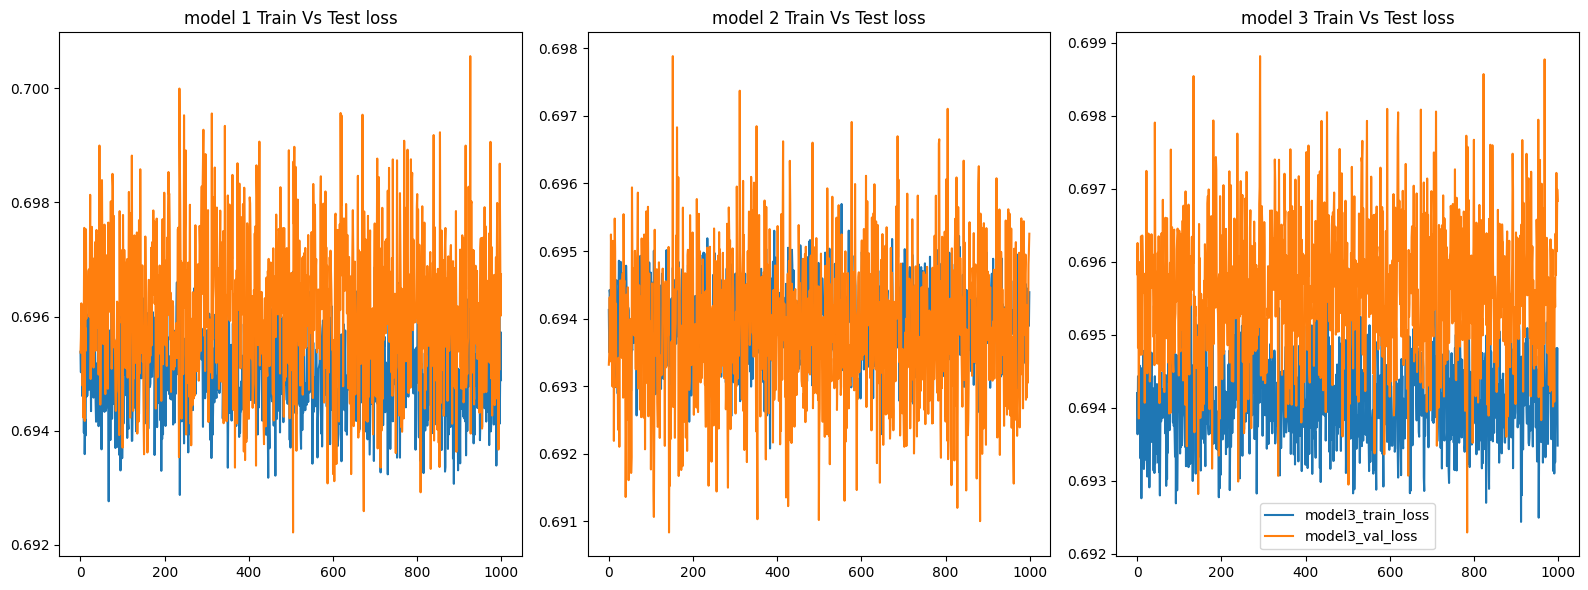

In [42]:
fig, axis = plt.subplots(1, 3, figsize = (16, 6))
axis[0].plot(np.array(MODEL1_TL), label = 'model1_train_loss')
axis[0].plot(np.array(MODEL1_VL), label = 'model1_val_loss')
axis[0].set_title('model 1 Train Vs Test loss')

axis[1].plot(np.array(MODEL2_TL), label = 'model2_train_loss')
axis[1].plot(np.array(MODEL2_VL), label = 'model2_val_loss')
axis[1].set_title('model 2 Train Vs Test loss')

axis[2].plot(np.array(MODEL3_TL), label = 'model3_train_loss')
axis[2].plot(np.array(MODEL3_VL), label = 'model3_val_loss')
axis[2].set_title('model 3 Train Vs Test loss')


plt.legend()
plt.tight_layout()
plt.show()

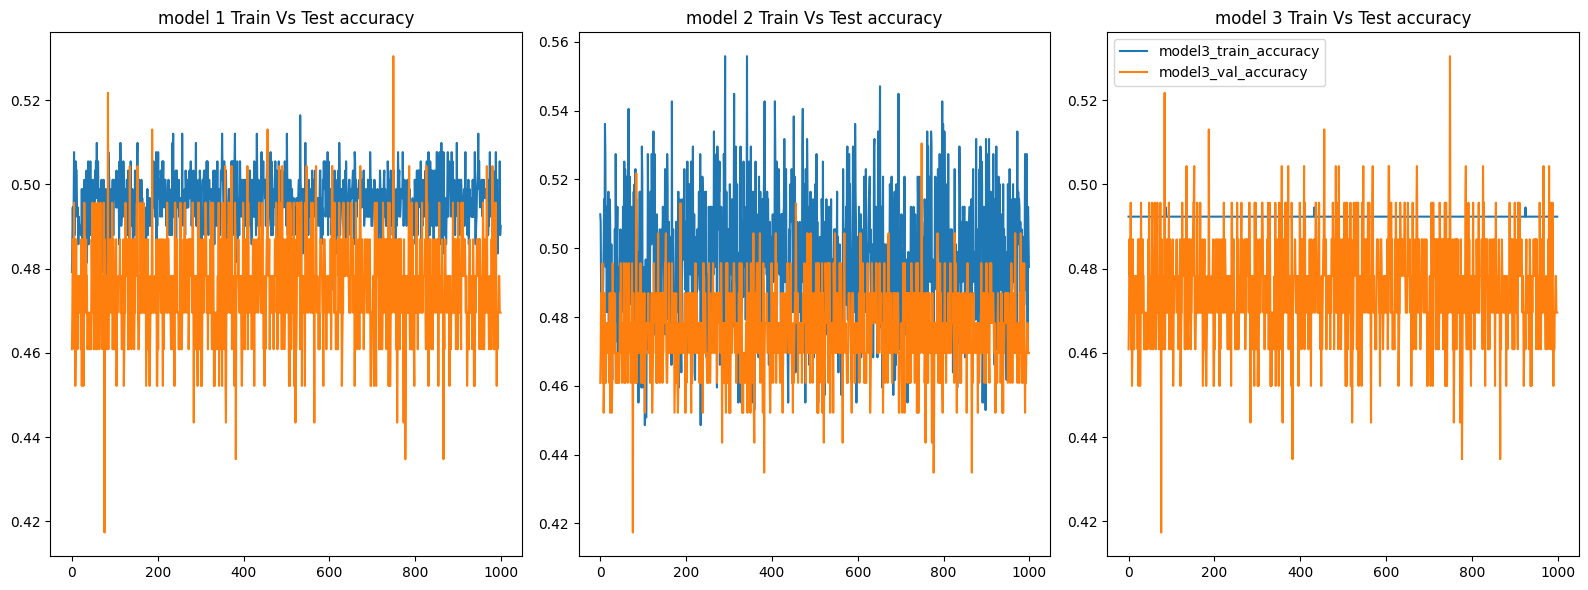

In [44]:
fig, axis = plt.subplots(1, 3, figsize = (16, 6))
axis[0].plot(np.array(MODEL1_ACC), label = 'model1_train_accuracy')
axis[0].plot(np.array(MODEL1_VAL_ACC), label = 'model1_val_accuracy')
axis[0].set_title('model 1 Train Vs Test accuracy')

axis[1].plot(np.array(MODEL2_ACC), label = 'model2_train_accuracy')
axis[1].plot(np.array(MODEL1_VAL_ACC), label = 'model2_val_accuracy')
axis[1].set_title('model 2 Train Vs Test accuracy')

axis[2].plot(np.array(MODEL3_ACC), label = 'model3_train_accuracy')
axis[2].plot(np.array(MODEL1_VAL_ACC), label = 'model3_val_accuracy')
axis[2].set_title('model 3 Train Vs Test accuracy')


plt.legend()
plt.tight_layout()
plt.show()

#####Evaluation

In [48]:
TEST_LABELS  = []
TEST_PREDICT = []

for test_data, test_label in TEST_LOADER:
  test_label = test_label.long()
  test_data  = test_data.to(device)
  test_label = test_label.to(device)

  MAJORITY_VOTING = []

  model1, model2, model3 = model(test_data)

  model1_prediction = torch.argmax(model1, 1).cpu().flatten().detach().numpy()
  model2_prediction = torch.argmax(model2, 1).cpu().flatten().detach().numpy()
  model3_prediction = torch.argmax(model3, 1).cpu().flatten().detach().numpy()

  model_actutal = test_label.cpu().flatten().detach().numpy()

  for PREDICT1, PREDICT2, PREDICT3 in zip(model1_prediction, model2_prediction, model3_prediction):
    count_values = Counter([PREDICT1, PREDICT2, PREDICT3])
    MAJORITY_VOTING.append(list(dict(sorted(count_values.items(), key = lambda item: item[1], reverse = True)).keys())[0])

  TEST_PREDICT.extend(MAJORITY_VOTING)
  TEST_LABELS.extend(model_actutal)


print("accuracy  # {} ".upper().format(accuracy_score(TEST_LABELS, TEST_PREDICT)),'\n')
print("precision # {} ".upper().format(precision_score(TEST_LABELS, TEST_PREDICT, average = 'macro')),'\n')
print("recall    # {} ".upper().format(recall_score(TEST_LABELS, TEST_PREDICT, average = 'macro')),'\n')
print("f1_score  # {} ".upper().format(f1_score(TEST_LABELS, TEST_PREDICT, average = 'macro')))

ACCURACY  # 0.4782608695652174  

PRECISION # 0.7368421052631579  

RECALL    # 0.5081967213114754  

F1_SCORE  # 0.33755760368663595 
